# PSPNet
論文  
https://arxiv.org/pdf/1612.01105.pdf  
解説記事   
https://tarovel4842.hatenablog.com/entry/2019/11/15/180322  
https://blog.negativemind.com/2019/03/19/semantic-segmentation-by-pyramid-scene-parsing-network/  


In [112]:
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
from PIL import Image
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

In [74]:

def make_datapath_list(rootpath):
    """
    学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """

    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [75]:
for line in open('data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt'):
    print(line)

2007_000032

2007_000039

2007_000063

2007_000068

2007_000121

2007_000170

2007_000241

2007_000243

2007_000250

2007_000256

2007_000333

2007_000363

2007_000364

2007_000392

2007_000480

2007_000504

2007_000515

2007_000528

2007_000549

2007_000584

2007_000645

2007_000648

2007_000713

2007_000720

2007_000733

2007_000738

2007_000768

2007_000793

2007_000822

2007_000836

2007_000876

2007_000904

2007_001027

2007_001073

2007_001149

2007_001185

2007_001225

2007_001340

2007_001397

2007_001416

2007_001420

2007_001439

2007_001487

2007_001595

2007_001602

2007_001609

2007_001698

2007_001704

2007_001709

2007_001724

2007_001764

2007_001825

2007_001834

2007_001857

2007_001872

2007_001901

2007_001917

2007_001960

2007_002024

2007_002055

2007_002088

2007_002099

2007_002105

2007_002107

2007_002120

2007_002142

2007_002198

2007_002212

2007_002216

2007_002227

2007_002234

2007_002273

2007_002281

2007_002293

2007_002361

2007_002368

2007_002370


In [76]:
# 動作確認 ファイルパスのリストを取得
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

print(train_img_list[0])
print(train_anno_list[0])


./data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png


# Datasetの作成

In [22]:
class DataTransform:
    """
    画像とアノテーションの前処理クラス。訓練時と検証時で異なる動作をする。
    画像のサイズをinput_size x input_sizeにする。
    訓練時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (R, G, B)
        各色チャネルの平均値。
    color_std : (R, G, B)
        各色チャネルの標準偏差。
    """
      
    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train' : Compose([
                    Scale(scale=[0.5, 1.5]),
                    RandomRotation(angle=[-10, 10]),
                    RandomMirror(),
                    Resize(input_size),
                    Normalize_Tensor(color_mean, color_std)]),
            'val' : Compose([
                    Resize(input_size),
                    Normalize_Tensor(color_mean, color_std)
            ])}
            
    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, anno_class_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


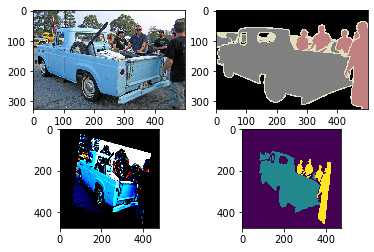

In [59]:
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(475, color_mean, color_std)
img = Image.open("data/VOCdevkit/VOC2012/JPEGImages/2010_002929.jpg")
anno_img = Image.open("data/VOCdevkit/VOC2012/SegmentationClass/2010_002929.png")

img_transformed, anno_img_transformed = transform('train', img, anno_img)
img_transformed = img_transformed.numpy().transpose(1, 2, 0)
anno_img_transformed = anno_img_transformed.numpy()

fig = plt.figure()
plt.subplot(2,2,1)
plt.imshow(img)
plt.subplot(2,2,2)
plt.imshow(anno_img)
plt.subplot(2,2,3)
plt.imshow(img_transformed)
plt.subplot(2,2,4)
plt.imshow(anno_img_transformed)

plt.show()

In [84]:
class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    """
    
    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img
        
    def pull_item(self, index):
        img = Image.open(self.img_list[index])
        anno_img = Image.open(self.anno_list[index])
        
        img, anno_img = self.transform(self.phase, img, anno_img)
        return img, anno_img

In [85]:
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train', 
                                                   transform=DataTransform(input_size=475, 
                                                                                                  color_mean=color_mean,
                                                                                                  color_std=color_std))
val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val',
                                                transform=DataTransform(input_size=475,
                                                                                               color_mean=color_mean,
                                                                                               color_std=color_std))

print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)

torch.Size([3, 475, 475])
torch.Size([475, 475])


# DataLoaderを作成

In [87]:
batch_size = 8

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size,
                                                              num_workers=4, shuffle=True)

val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size,
                                                              num_workers=4, shuffle=False)

dataloader_dict = {'train':train_dataloader, 'val':val_dataloader}

batch_iterator = iter(dataloader_dict['val'])
img, anno_img = next(batch_iterator)
print(img.size())
print(anno_img.size())

torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


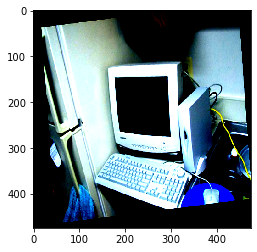

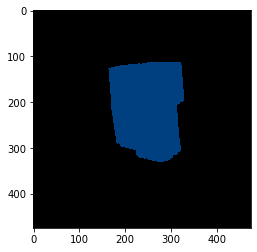

In [104]:
# 実行するたびに変わります

# 画像データの読み込み
# 画像処理後
index = 1
imges, anno_class_imges = train_dataset.__getitem__(index) 

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette() # 元画像のカラーパレットを取得

anno_class_img_val = anno_class_imges.numpy()
# mode=Pで画像を変換
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette) # 元のカラーパレットを当てはめる
plt.imshow(anno_class_img_val)
plt.show()


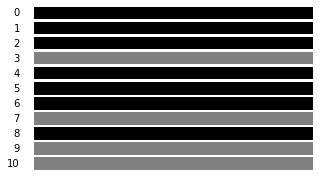

In [110]:
fig, axes_list = plt.subplots(11, 1, figsize=(5, 3))
for i, color in enumerate(p_palette[:11]):
    color_img = np.full((1, 10, 3), color, dtype=np.uint8)
    axes_list[i].imshow(color_img, aspect='auto')
    axes_list[i].set_axis_off()
    axes_list[i].text(-1, 0, i, va='center', ha='right', fontsize=10)

plt.show()

In [115]:
class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super(PSPNet, self).__init__()
        
        block_config = [3, 4, 6, 3]  # resnet50
        img_size = 475
        img_size_8 = 60 # img_sizeの1/8に
        
        # 4つのモジュールを構成するサブネットワークの用意
        self.feature_conv = FeatureMap_convolution()
        
        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, 
            mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, 
            mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, 
            mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, 
            mid_channels=512, out_channels=2048, stride=1, dilation=4)
        
        self.pyramid_pooling = PyramidPooling(in_channels=2048, 
                                                                             pool_sizes=[6, 3, 2, 1],
                                                                             height=img_size_8,
                                                                             width=img_size_8)
        
        self.decode_feature = DecodePSPFeature(height=img_size,
                                                                                  width=img_size,
                                                                                  n_classes=n_classes)
        
        self.aux = AuxiliaryPSPlayers(in_channels=1024,
                                                          height=img_size,
                                                          width=img_size,
                                                          n_classes=n_classes)
        
    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)
        
        output_aux = selfl.aux(x) # Featureモジュールの途中をAuxモジュールへ
        
        x = self.feature_dilated_res_2(x)
        
        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)
        
        return (output, output_aux)

# 3.4 Featureモジュール

In [117]:
class conv2DBatchNormReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormReLU, self).__init__()
        # bias=Trueで学習可能なバイアス項を出力に出す
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, dilation, bias=bias)
        self.batch = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        
        return x

In [118]:
class FeatureMap_convolution(nn.Module):
    def __init__(self):
        super(FeatureMap_convolution, self).__init__()
        
        self.cbnr_1 = conv2DBatchNormReLU(in_channels=3, 
                                                                          output_channels=64,
                                                                          kernel_size=3,
                                                                          stride=2,
                                                                          padding=1,
                                                                          dilation=1,
                                                                          bias=False)
        self.cbnr_2 = conv2DBatchNormReLU(in_channels=64, 
                                                                          output_channels=64,
                                                                          kernel_size=3,
                                                                          stride=1,
                                                                          padding=1,
                                                                          dilation=1,
                                                                          bias=False)
        
        self.cbnr_3 = conv2DBatchNormReLU(in_channels=64, 
                                                                          output_channels=128,
                                                                          kernel_size=3,
                                                                          stride=1,
                                                                          padding=1,
                                                                          dilation=1,
                                                                          bias=False)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        
        return outputs